Error_L2 : 1.81e+00
Error_max : 4.42e-01
static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


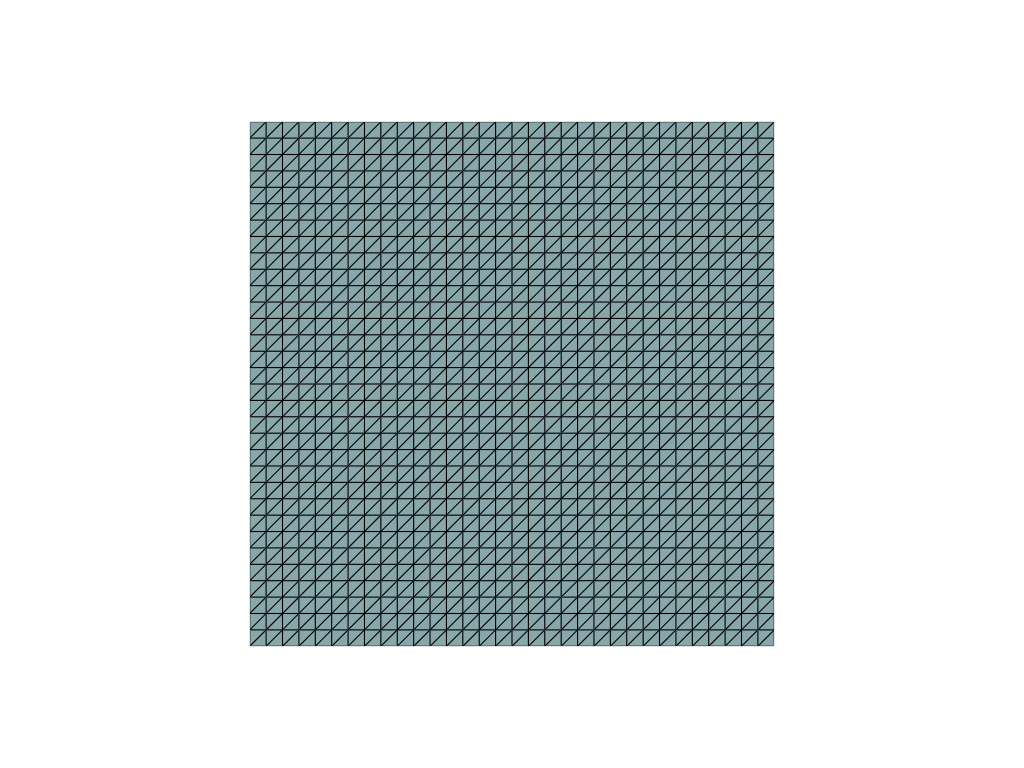

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


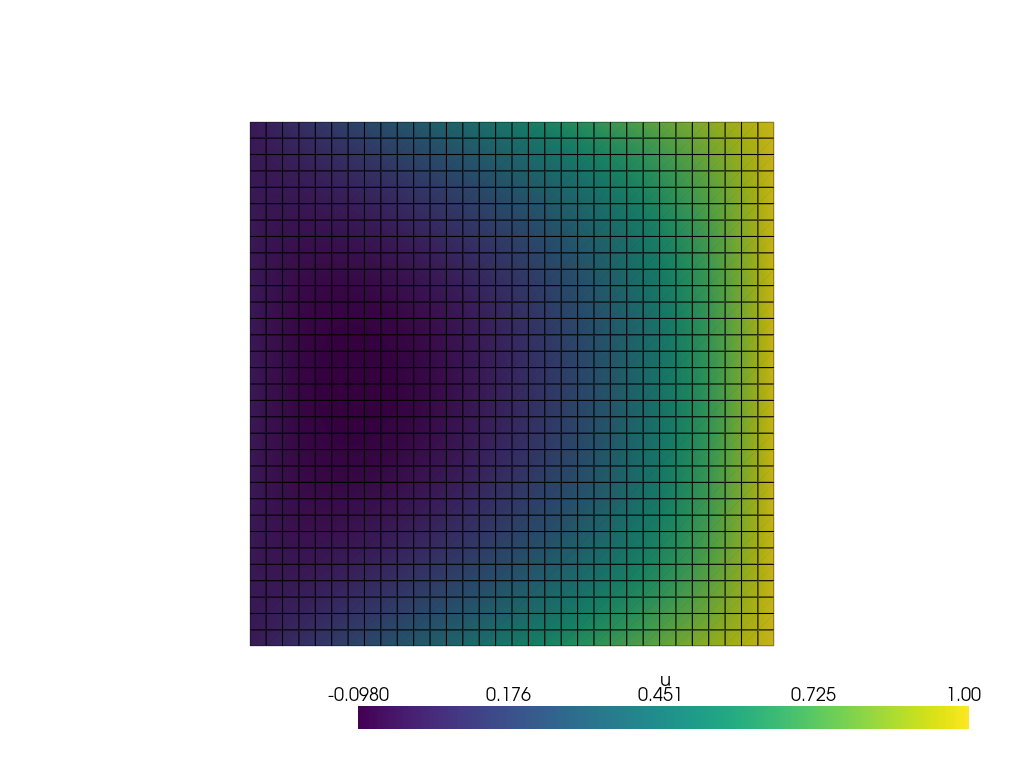

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


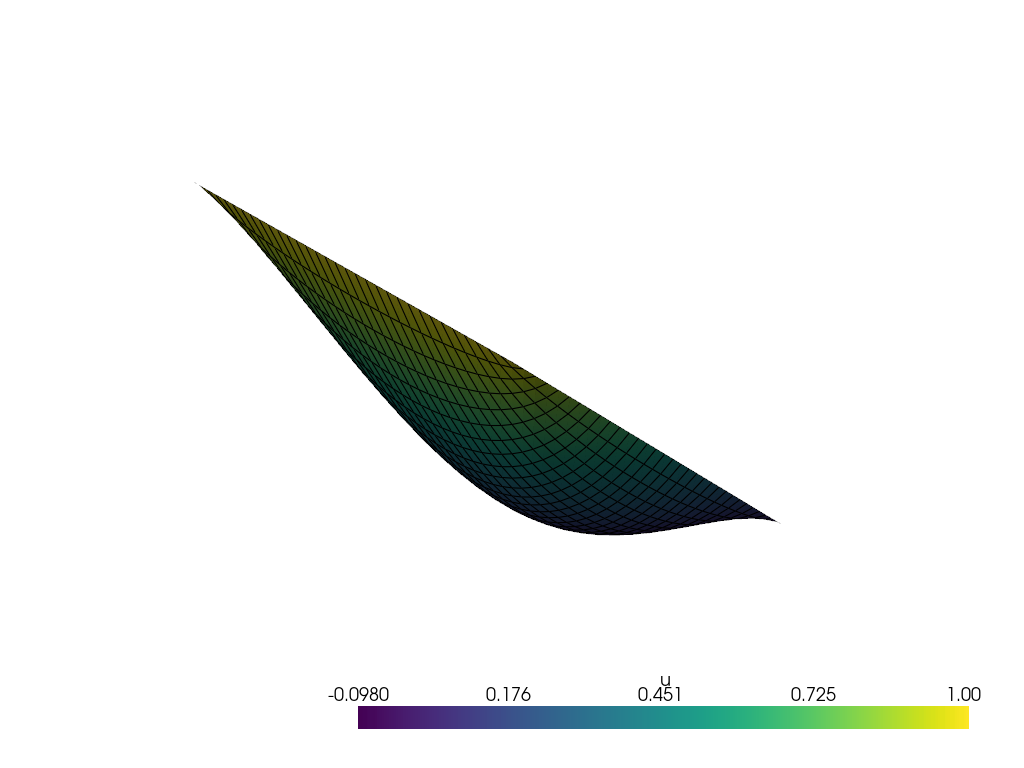

In [1]:
from mpi4py import MPI
from dolfinx import mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)#, mesh.CellType.quadrilateral)

from dolfinx.fem import functionspace
V = functionspace(domain, ("Lagrange", 1))

from dolfinx import fem
uD = fem.Function(V)
uD.interpolate(lambda x: x[0]) #1 + x[0]**2 + 2 * x[1]**2)

import numpy
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

from dolfinx import default_scalar_type
f = fem.Constant(domain, default_scalar_type(-6))

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

V2 = fem.functionspace(domain, ("Lagrange", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

error_max = numpy.max(numpy.abs(uD.x.array-uh.x.array))
# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

import pyvista
print(pyvista.global_theme.jupyter_backend)

from dolfinx import plot
pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()

from dolfinx import io
from pathlib import Path
results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "fundamentals"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

```{bibliography}
   :filter: cited and ({"chapter1/fundamentals_code"} >= docnames)
```